In [1]:
import tqdm
import pickle
import warnings
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from meteostat import Point, Daily

from statsmodels.tsa.seasonal import STL

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [2]:
sns.set()
pd.options.display.float_format = "{:,.2f}".format

warnings.simplefilter("ignore")

# Загрузка и обработка данных

Загружаем датасет с 10-летней информацией о погоде в СПб.

In [3]:
data = pd.read_csv("custom_dataset.csv")

In [4]:
data["time"] = pd.to_datetime(data["time"], format="%Y-%m-%d")
data.set_index("time", inplace=True)

In [5]:
data.head()

,tavg,prcp,wdir,wspd,wpgt,pres
time,,,,,,
2014-01-01,-4.88,0.00,223.01,17.12,37.00,"1,020.25"
2014-01-02,-5.88,0.00,170.19,10.75,21.00,"1,022.00"
2014-01-03,-6.62,0.00,154.10,11.88,20.00,"1,019.00"
2014-01-04,-4.50,0.05,162.60,12.62,22.00,"1,012.75"
2014-01-05,-2.38,0.06,209.76,11.00,22.00,"1,011.25"


In [6]:
start_date = data.index[0]

In [7]:
data.isna().sum()

tavg    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64

Как видим, в нем нет пропусков.

# Анализ данных

In [8]:
data.mean()

tavg       3.45
prcp       0.08
wdir     199.44
wspd      13.21
wpgt      30.12
pres   1,012.99
dtype: float64

Теперь визуализируем данные.

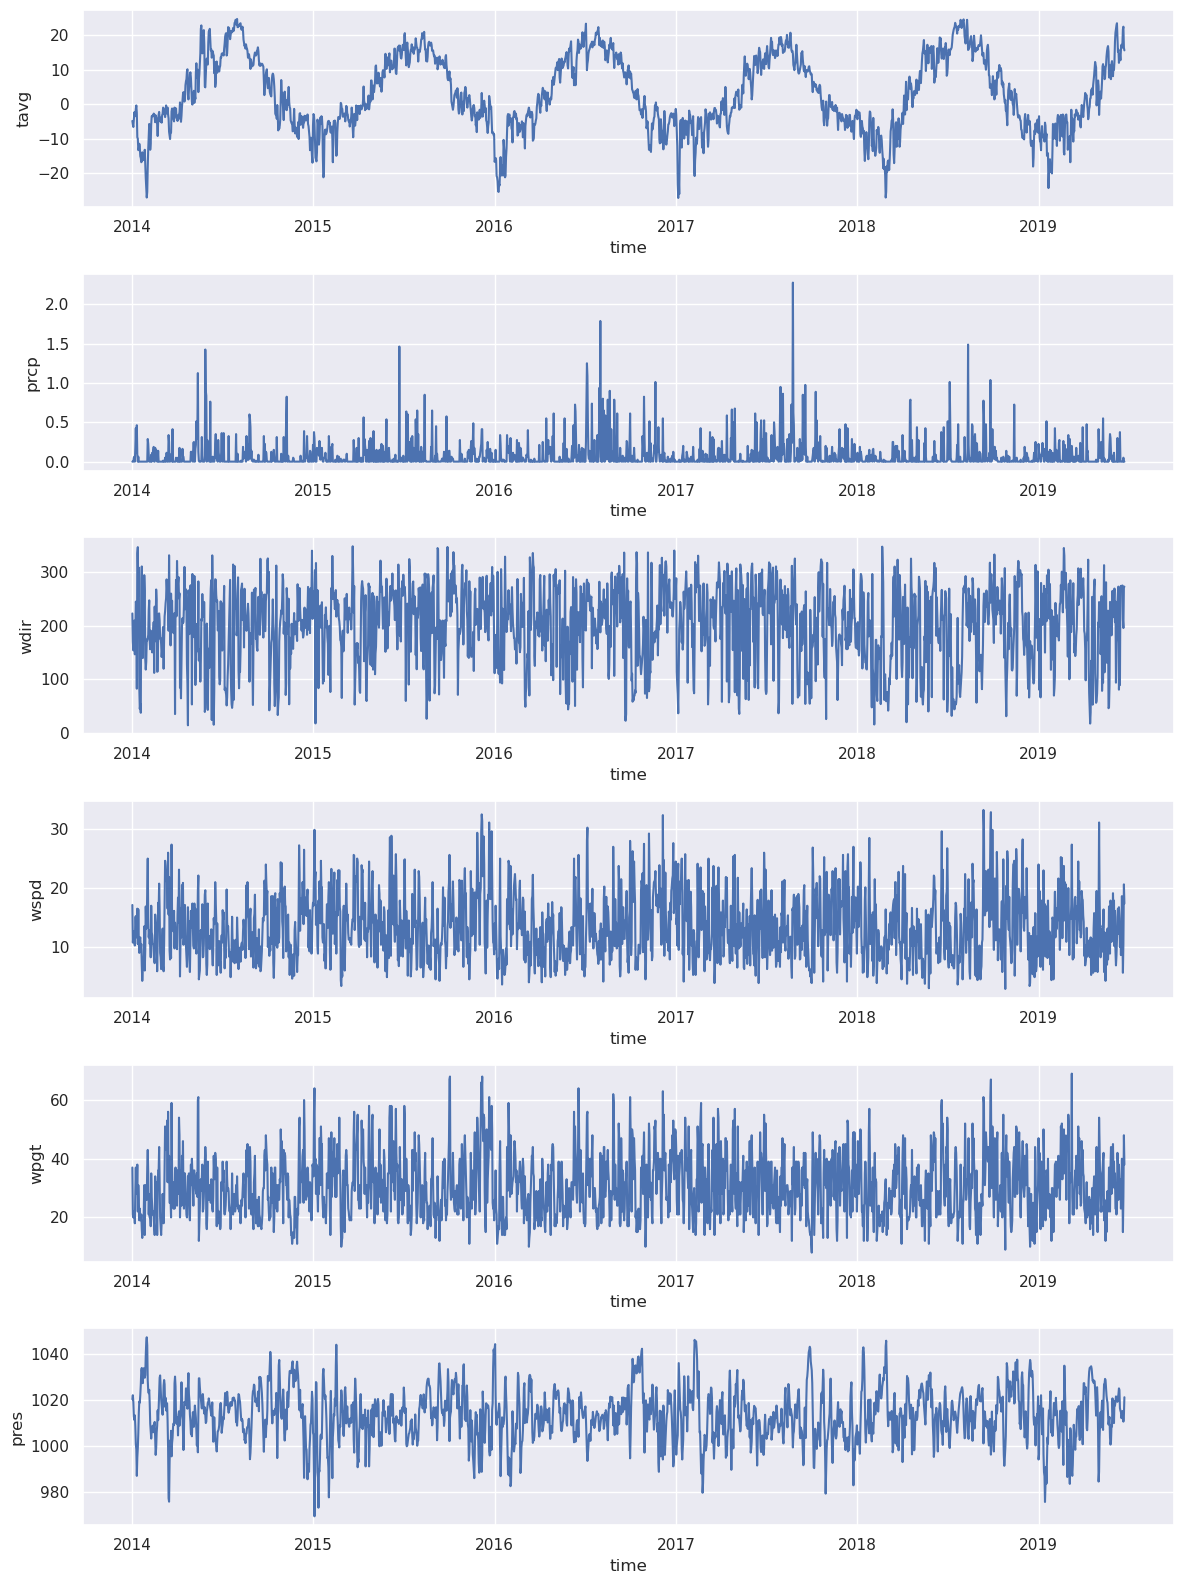

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 16))

for i, column in enumerate(data.columns):
    sns.lineplot(ax=axes[i], data=data[column][:2000])

plt.tight_layout()
plt.show()

Теперь посмотрим на корреляции между данными.

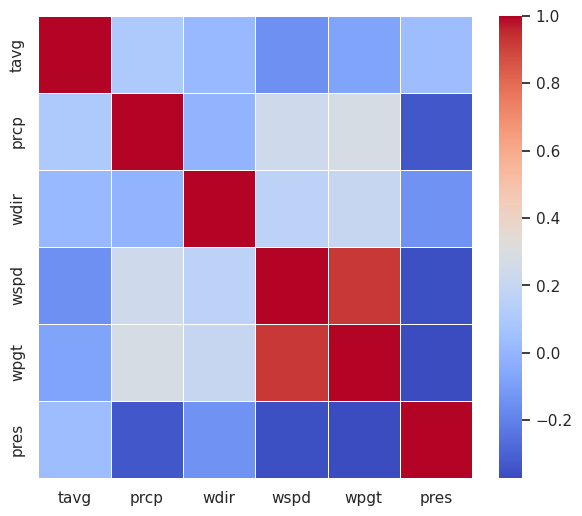

In [10]:
plt.figure(figsize=(7, 6))
sns.heatmap(data.corr(), cmap="coolwarm", linewidths=.5)
plt.show()

Посмотрим, как температура разбивается на компоненты, как временной ряд:

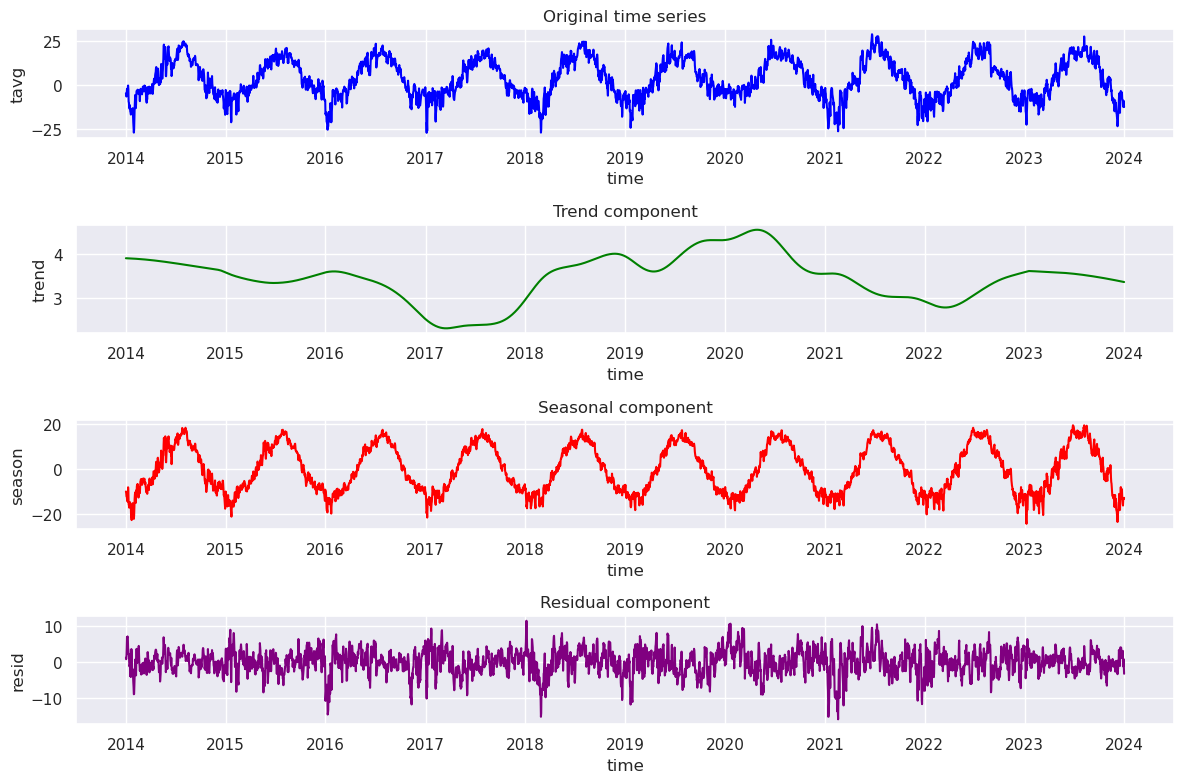

In [11]:
stl = STL(data["tavg"], period=365)
result = stl.fit()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
sns.lineplot(data["tavg"], color="blue")
plt.title("Original time series")

plt.subplot(4, 1, 2)
sns.lineplot(result.trend, color="green")
plt.title("Trend component")

plt.subplot(4, 1, 3)
sns.lineplot(result.seasonal, color="red")
plt.title("Seasonal component")

plt.subplot(4, 1, 4)
sns.lineplot(result.resid, color="purple")
plt.title("Residual component")

plt.tight_layout()
plt.show()

# Обучение моделей

В качестве тестового датасета будем использовать данные за последний год.

In [12]:
data_train = data[:-365].copy()
data_test = data[-365:].copy()

Т.к. мы будем использовать линейные модели, а не только деревья, отнормируем данные.

In [13]:
cols = list(data.columns.drop("tavg"))

feature_scaler = StandardScaler()
data_train[cols] = feature_scaler.fit_transform(data_train[cols])
data_test[cols] = feature_scaler.transform(data_test[cols])

target_scaler = StandardScaler()
data_train["tavg"] = target_scaler.fit_transform(data_train["tavg"].values.reshape(-1, 1))
data_test["tavg"] = target_scaler.transform(data_test["tavg"].values.reshape(-1, 1))

### Реализация гибридной, рекурсивной и прямой стратегии

In [14]:
def extract_features(data: pd.DataFrame, model_idx: int, window_size: int = 3, mode: str = "hybrid"):
    if mode == "hybrid":
        feature_window = window_size + model_idx
        data = data[-feature_window:]
    elif mode == "recursive":
        feature_window = window_size
        data = data[-feature_window:]
    elif mode == "direct":
        feature_window = window_size
        data = data[-feature_window:]["tavg"]
        
    values = data.values.reshape(-1)
    date = data.index[-1] + datetime.timedelta(days=1 + model_idx)
    day = (date - start_date).days
    month = date.month
    return np.concatenate([values, [day, month]])

In [15]:
def build_datasets(data: pd.DataFrame, window_size: int = 3, model_count: int = 3, mode: str = "hybrid"):
    datasets = []
    n = len(data)
        
    for i in range(model_count):  
        features = np.array([extract_features(data[:j], i, window_size, mode) for j in range(window_size + i, n)])
        targets = data[window_size + i:]
        if mode == "direct":
            targets = targets["tavg"]
        datasets.append((features, targets.values))

    return datasets

In [16]:
def train_models(data: pd.DataFrame, model_type, model_kwargs, model_count: int = 3, window_size: int = 3, mode: str = "hybrid"):
    models = []

    if mode == "recursive":
        dataset = build_datasets(data, window_size, 1, mode)[0]
        model = MultiOutputRegressor(model_type(**model_kwargs))
        model.fit(*dataset)
        return [model] * model_count

    datasets = build_datasets(data, window_size, model_count, mode)
    
    for i in range(model_count):
        if mode == "direct":
            model = model_type(**model_kwargs)
        elif mode == "hybrid":
            model = MultiOutputRegressor(model_type(**model_kwargs))
        model.fit(*datasets[i])
        models.append(model)

    return models

In [17]:
def predict(data: pd.DataFrame, models, target_scaler, window_size: int = 3, mode: str = "hybrid"):    
    last_date = data.index[-1]
    predictions = pd.Series()
    
    for i, model in enumerate(models):
        features = extract_features(data, i, window_size, mode).reshape(1, -1)
        last_date += datetime.timedelta(days=1)
        if mode == "direct":
            prediction = pd.Series([model.predict(features)], index=[last_date])
            predictions = pd.concat([predictions, prediction], axis=0)
        else:
            prediction = pd.DataFrame(model.predict(features), index=[last_date], columns=data.columns)
            data = pd.concat([data, prediction], axis=0)
            predictions = pd.concat([predictions, prediction["tavg"]], axis=0)

    predictions.iloc[:] = target_scaler.inverse_transform(predictions.values.reshape(-1, 1)).reshape(-1)

    return predictions

In [18]:
def score_models(data_test, models, target_scaler, window_size: int = 3, mode: str = "hybrid"):
    input_size = len(data_test)
    predict_size = len(models)

    n_predictions = input_size - window_size - predict_size + 1
    predictions = np.zeros((n_predictions, predict_size))
    targets = np.zeros((n_predictions, predict_size))

    for i in range(n_predictions):
        predictions[i] = predict(data_test[:window_size + i], models, target_scaler, window_size, mode).values
        targets[i] = data_test[window_size + i:window_size + predict_size + i]["tavg"].values

    h, w = targets.shape
    targets = target_scaler.inverse_transform(targets.reshape(-1, 1)).reshape(h, w)

    return np.mean(np.abs(targets - predictions), axis=0)

In [19]:
window_size = 15
predict_size = 15

modes = ["direct", "recursive", "hybrid"]
estimators = {"Linear regression": (LinearRegression, {}),
              "Gradient boosting": (CatBoostRegressor, {"verbose": 0})}

result_models = {}
result_scores = {}

bar = tqdm.tqdm(range(len(modes) * len(estimators)), desc="Training")

for mode in modes:
    result_models[mode] = {}
    result_scores[mode] = {}
    for estimator_name, (estimator, params) in estimators.items():
        models = train_models(data_train, estimator, params, predict_size, window_size, mode)
        result_models[mode][estimator_name] = models
        scores = score_models(data_test, models, target_scaler, window_size, mode)
        result_scores[mode][estimator_name] = scores
        bar.update()

Training: 100%|██████████████████████████████████| 6/6 [15:45<00:00, 289.78s/it]

# Визуализация результатов обучения

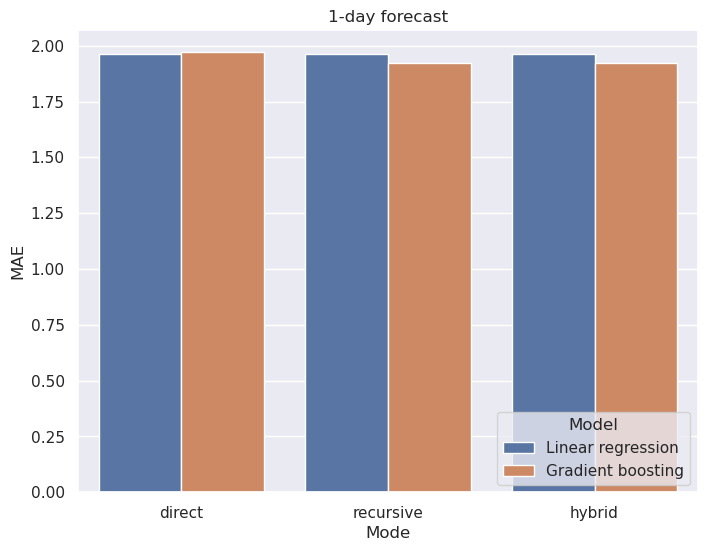

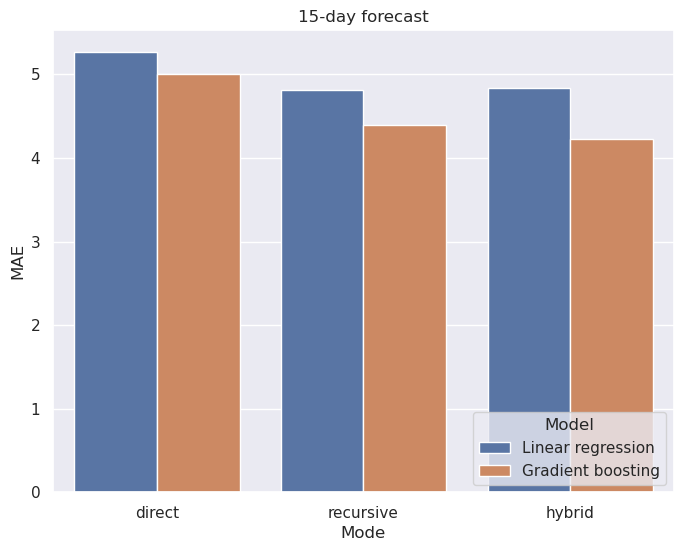

In [20]:
rows = []
for train_mode, models in result_scores.items():
    for model, values in models.items():
        rows.append([train_mode, model, values[0], values[14]])

df = pd.DataFrame(rows, columns=["train_mode", "model", "1-day forecast", "15-day forecast"])

value_names = ["1-day forecast", "15-day forecast"]

for value_name in value_names:
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x="train_mode", y=value_name, hue="model", dodge=True)
    plt.title(value_name)
    plt.xlabel("Mode")
    plt.ylabel("MAE")
    plt.legend(title="Model", loc="lower right")
    plt.show()

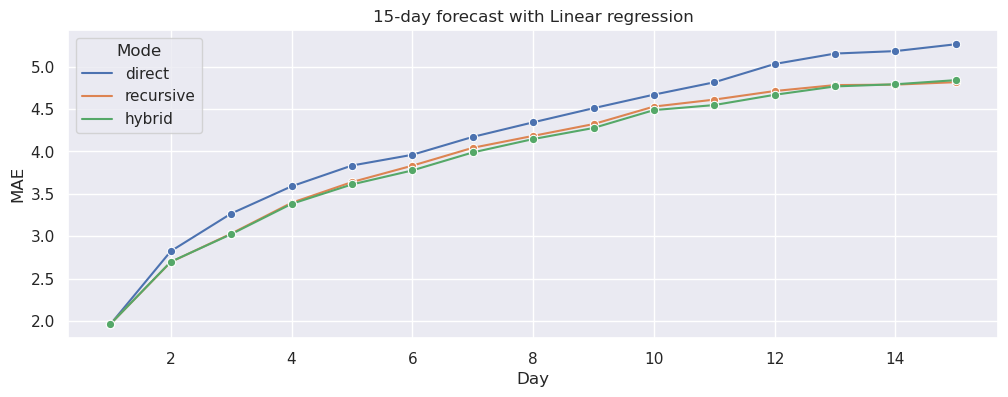

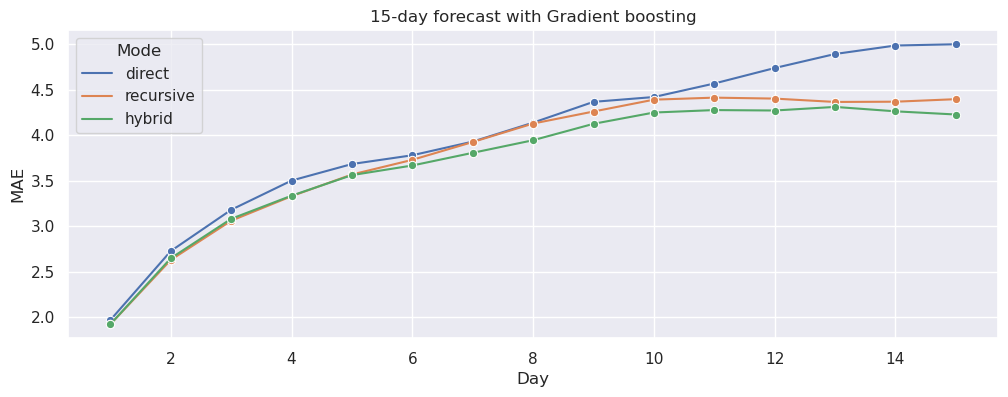

In [21]:
for model_name in estimators:
    rows = []
    for train_mode, models in result_scores.items():
        if model_name in models:
            values = models[model_name]
            rows.append([train_mode] + list(values))
    
    columns = ["train_mode"] + [f"value_{i}" for i in range(1, 16)]
    df = pd.DataFrame(rows, columns=columns)
    
    df_melted = df.melt(id_vars="train_mode", var_name="value_index", value_name="value")
    df_melted["value_index"] = df_melted["value_index"].str.extract("(\d+)").astype(int)
    
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df_melted, x="value_index", y="value", hue="train_mode", marker="o")
    plt.title(f"15-day forecast with {model_name}")
    plt.xlabel("Day")
    plt.ylabel("MAE")
    plt.legend(title="Mode")
    plt.show()

### Сохранение лучшей модели

In [22]:
with open("model.pkl", "wb") as file:
    pickle.dump([feature_scaler, target_scaler, result_models["hybrid"]["Gradient boosting"]], file)